## Data quality check / cleaning / preparation 

### Data quality check
By Daniel Lee

In [1]:
import pandas as pd
from datetime import datetime
import seaborn as sns
import statsmodels.formula.api as smf
import statsmodels.api as sm
import matplotlib.pyplot as plt
import numpy as np

***The code below shows the distribution of the different variables we worked with for our analysis by showing visualizations and describing the relevant distribution information (.describe)***

In [2]:
# Downloading the dataset 
df = pd.read_csv('complete_dataset.csv')
df['date'] = pd.to_datetime(df['date'])

Text(0.5, 0, 'Demand')

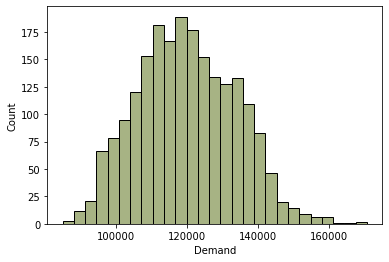

In [3]:
# Plotting the distribution of demand data
sns.histplot(data=df['demand'], color='#8A9A5B')
plt.xlabel('Demand')

In [4]:
# seeing how many null values there are
print(df.isnull().sum())

date               0
demand             0
RRP                0
demand_pos_RRP     0
RRP_positive       0
demand_neg_RRP     0
RRP_negative       0
frac_at_neg_RRP    0
min_temperature    0
max_temperature    0
solar_exposure     1
rainfall           3
school_day         0
holiday            0
dtype: int64


In [5]:
df.describe()

,demand,RRP,demand_pos_RRP,RRP_positive,demand_neg_RRP,RRP_negative,frac_at_neg_RRP,min_temperature,max_temperature,solar_exposure,rainfall
count,2106.000000,2106.000000,2106.000000,2106.000000,2106.000000,2106.000000,2106.000000,2106.000000,2106.000000,2105.000000,2103.000000
mean,120035.476503,76.079554,119252.305055,76.553847,783.171448,-2.686052,0.008547,11.582289,20.413200,14.743373,1.505944
std,13747.993761,130.246805,14818.631319,130.114184,3578.920686,19.485432,0.039963,4.313711,6.288693,7.945527,4.307897
min,85094.375000,-6.076028,41988.240000,13.568986,0.000000,-342.220000,0.000000,0.600000,9.000000,0.700000,0.000000
25%,109963.650000,38.707040,109246.250000,39.117361,0.000000,0.000000,0.000000,8.500000,15.525000,8.200000,0.000000
50%,119585.912500,66.596738,119148.082500,66.869058,0.000000,0.000000,0.000000,11.300000,19.100000,12.700000,0.000000
75%,130436.006250,95.075012,130119.477500,95.130181,0.000000,0.000000,0.000000,14.600000,23.900000,20.700000,0.800000
max,170653.840000,4549.645105,170653.840000,4549.645105,57597.595000,0.000000,0.625000,28.000000,43.500000,33.300000,54.600000


### Data cleaning and Data Preparation
*By Lauren Lin*

From the data quality check we realized that:

1. There were 4 NA values in this dataset, 1 for solar_exposure and 3 for rainfall, so we imputed them with the means of their respective variables. For example, since the mean of df['solar_exposure'] is 14.74337292161519, we replaced the NA value of solar_exposure with 14.74337292161519.
2. In addition to imputing NA values, we changed the values of'school_day' and 'holiday' ('N' and 'Y') to a binary of 0 and 1 so that they could be added to our regression model.

The code below implements the above cleaning.

In [6]:
# Changing values to more easily fit by changing to 1s and 0s instead of Y or N
df['school_day'] = df['school_day'].apply(lambda x: 1 if x == 'Y' else 0)
df['holiday'] = df['holiday'].apply(lambda x: 1 if x == 'Y' else 0)

In [7]:
# 4 NAN values that were imputed
print(df['solar_exposure'].mean())
df.at[1060, 'solar_exposure']=14.74337292161519

print(df['rainfall'].mean())
df.at[161, 'rainfall']=1.505943889681408
df.at[1377, 'rainfall']=1.505943889681408
df.at[1378, 'rainfall']=1.505943889681408

14.74337292161519
1.505943889681408


## Exploratory data analysis

*By Lauren Lin*


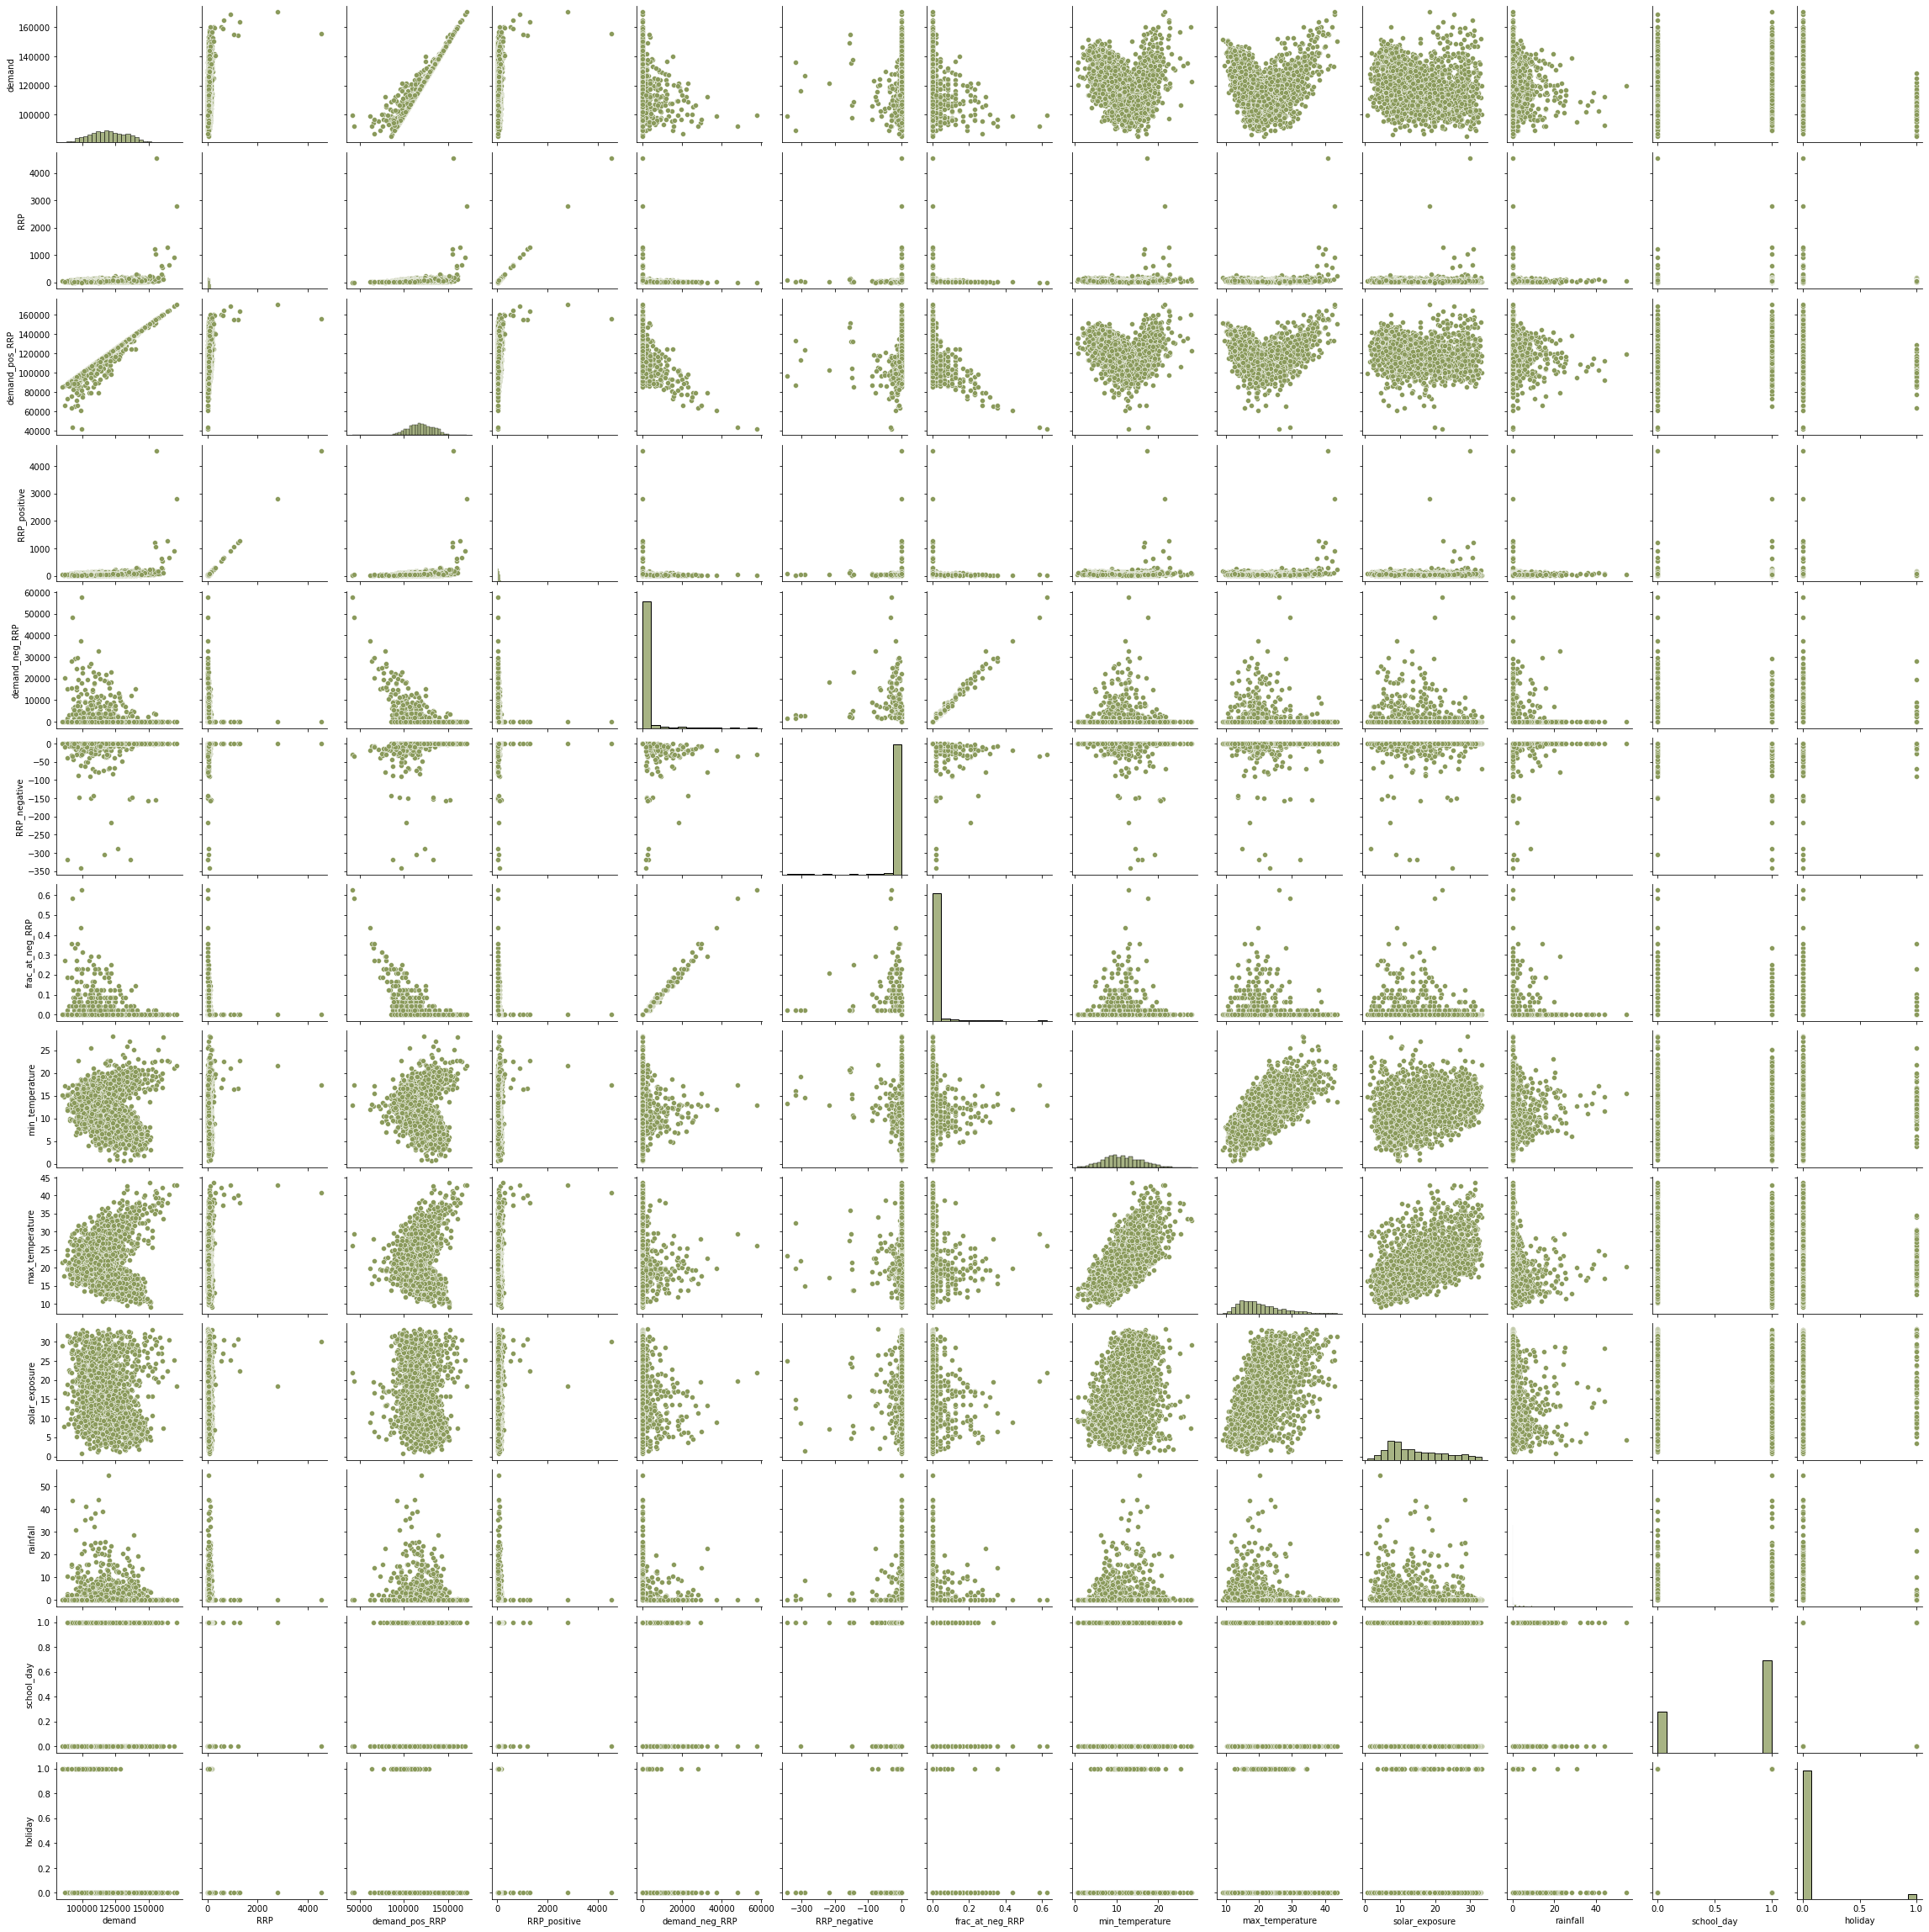

In [8]:
# Make pairplot of the dataframe to explore relationships between variables
sns.pairplot(df, plot_kws={'color':'#8A9A5B'}, diag_kws={'color':'#8A9A5B'})

- There is an obvious quadratic relationship between demand and min_temperature and demand and max_temperature
- It seems that solar_exposure might also have a quadratic relationship with demand, but a residual plot should be graphed to confirm
- Whether rainfall, school_day, and/or holiday have an effect on demand is unclear. They should be included in the first model so that we can check their p-values.

Text(0, 0.5, 'Demand')

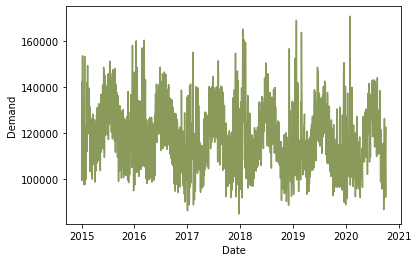

In [9]:
# Looking at relationship between date and demand
sns.lineplot(x='date', y='demand', data=df, color = '#8A9A5B')
plt.xlabel('Date')
plt.ylabel('Demand')

- The repeating patterns in the lineplot of demand against date indicate autocorrelation.

In [10]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# Calculating VIF

X = df[['max_temperature', 'min_temperature', 'solar_exposure', 'holiday', 'rainfall']]
X = add_constant(X, has_constant='add')
vif_data = pd.DataFrame()
vif_data['feature'] = X.columns

for i in range(len(X.columns)):
    X.columns[i]
    vif_data.loc[i,'VIF'] = variance_inflation_factor(X.values, i)

print(vif_data)

           feature        VIF
0            const  12.478907
1  max_temperature   2.768200
2  min_temperature   2.056258
3   solar_exposure   1.571803
4          holiday   1.005603
5         rainfall   1.050010


- All of the values of VIF are close to 1, so we do not need to be concerned about multicollinearity in our model.

## Developing the model

*By Jonny Myong and Jamie Park*


In [11]:
# Model 1 : multiple linear regression with max temp, min temp, solar exposure, school_day, and holiday
ols_object = smf.ols(formula = 'demand~max_temperature+min_temperature+solar_exposure+school_day+holiday+rainfall', data = df)
model1 = ols_object.fit()
print(model1.summary())

                            OLS Regression Results                            
Dep. Variable:                 demand   R-squared:                       0.166
Model:                            OLS   Adj. R-squared:                  0.163
Method:                 Least Squares   F-statistic:                     69.55
Date:                Sun, 12 Mar 2023   Prob (F-statistic):           3.46e-79
Time:                        16:31:01   Log-Likelihood:                -22864.
No. Observations:                2106   AIC:                         4.574e+04
Df Residuals:                    2099   BIC:                         4.578e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept        1.235e+05   1094.925    1

Text(0, 0.5, 'Residuals')

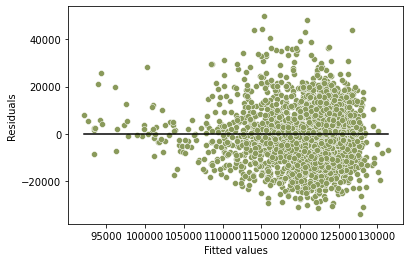

In [12]:
# Plotting residuals against fitted values
sns.scatterplot(x=model1.fittedvalues, y=model1.resid, color = '#8A9A5B')
sns.lineplot(x=[model1.fittedvalues.min(), model1.fittedvalues.max()], y=[0,0], color='black')
plt.xlabel('Fitted values')
plt.ylabel('Residuals')

Text(0, 0.5, 'Residuals')

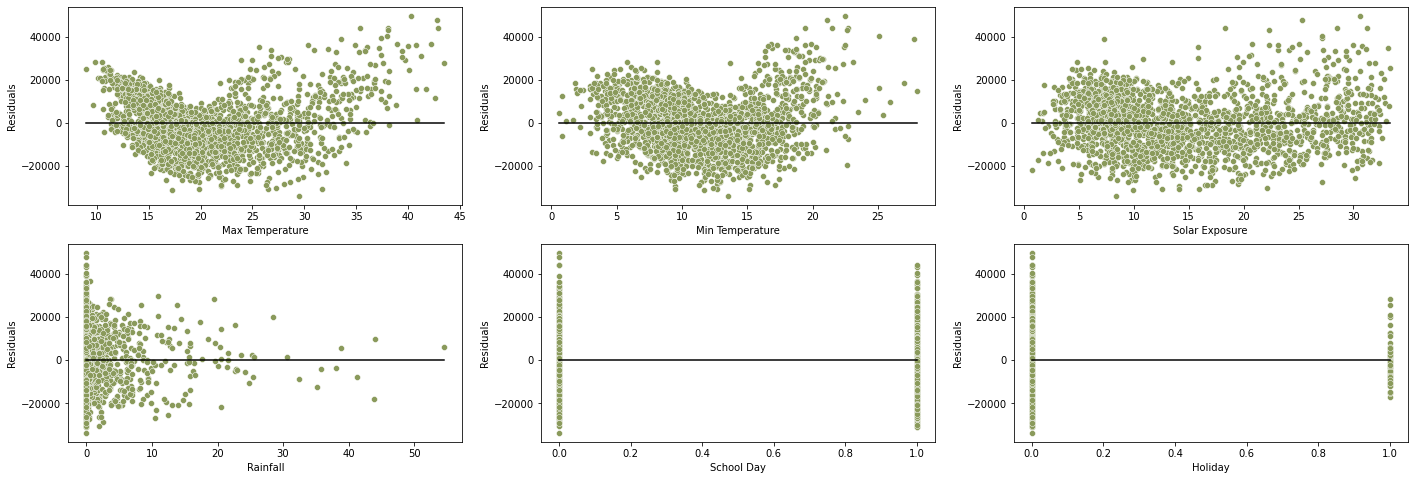

In [13]:
# Visualizing residuals of all the predictor variables
fig = plt.figure(figsize=(24, 8))
plt.subplot(2, 3, 1)
sns.scatterplot(x=df.max_temperature, y=model1.resid, color = '#8A9A5B')
sns.lineplot(x=[df.max_temperature.min(), df.max_temperature.max()], y=[0,0], color='black')
plt.xlabel('Max Temperature')
plt.ylabel('Residuals')

plt.subplot(2, 3, 2)
sns.scatterplot(x=df.min_temperature, y=model1.resid, color = '#8A9A5B')
sns.lineplot(x=[df.min_temperature.min(), df.min_temperature.max()], y=[0,0], color='black')
plt.xlabel('Min Temperature')
plt.ylabel('Residuals')

plt.subplot(2, 3, 3)
sns.scatterplot(x=df.solar_exposure, y=model1.resid, color = '#8A9A5B')
sns.lineplot(x=[df.solar_exposure.min(), df.solar_exposure.max()], y=[0,0], color='black')
plt.xlabel('Solar Exposure')
plt.ylabel('Residuals')

plt.subplot(2, 3, 4)
sns.scatterplot(x=df.rainfall, y=model1.resid, color = '#8A9A5B')
sns.lineplot(x=[df.rainfall.min(), df.rainfall.max()], y=[0,0], color='black')
plt.xlabel('Rainfall')
plt.ylabel('Residuals')

plt.subplot(2, 3, 5)
sns.scatterplot(x=df.school_day, y=model1.resid, color = '#8A9A5B')
sns.lineplot(x=[df.school_day.min(), df.school_day.max()], y=[0,0], color='black')
plt.xlabel('School Day')
plt.ylabel('Residuals')

plt.subplot(2, 3, 6)
sns.scatterplot(x=df.holiday, y=model1.resid, color = '#8A9A5B')
sns.lineplot(x=[df.holiday.min(), df.holiday.max()], y=[0,0], color='black')
plt.xlabel('Holiday')
plt.ylabel('Residuals')

#### Model 1 Conclusions:
- The response variable is heteroscedastic
- max temperature, min temperature, and solar exposure are quadratic

Put the code(s) that fit the final model(s) in separate cell(s), i.e., the code with the `.ols()` or `.logit()` functions.

In [14]:
# Model 2 : np.log(y) to resolve heterscedasticity
# and max_temperature, min_temperature, solar_exposure squared to fit linearity assumptions
ols_object = smf.ols(formula = 'np.log(demand)~max_temperature+I(max_temperature**2)+min_temperature+I(min_temperature**2)+solar_exposure+I(solar_exposure**2)+school_day+holiday+rainfall', data = df)
model2 = ols_object.fit()
print(model2.summary())

pred_demand = model2.predict(df)
print(np.sqrt((df['demand']-pred_demand)**2).mean())

                            OLS Regression Results                            
Dep. Variable:         np.log(demand)   R-squared:                       0.489
Model:                            OLS   Adj. R-squared:                  0.486
Method:                 Least Squares   F-statistic:                     222.6
Date:                Sun, 12 Mar 2023   Prob (F-statistic):          1.33e-297
Time:                        16:31:02   Log-Likelihood:                 2275.3
No. Observations:                2106   AIC:                            -4531.
Df Residuals:                    2096   BIC:                            -4474.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

Text(0, 0.5, 'Residuals')

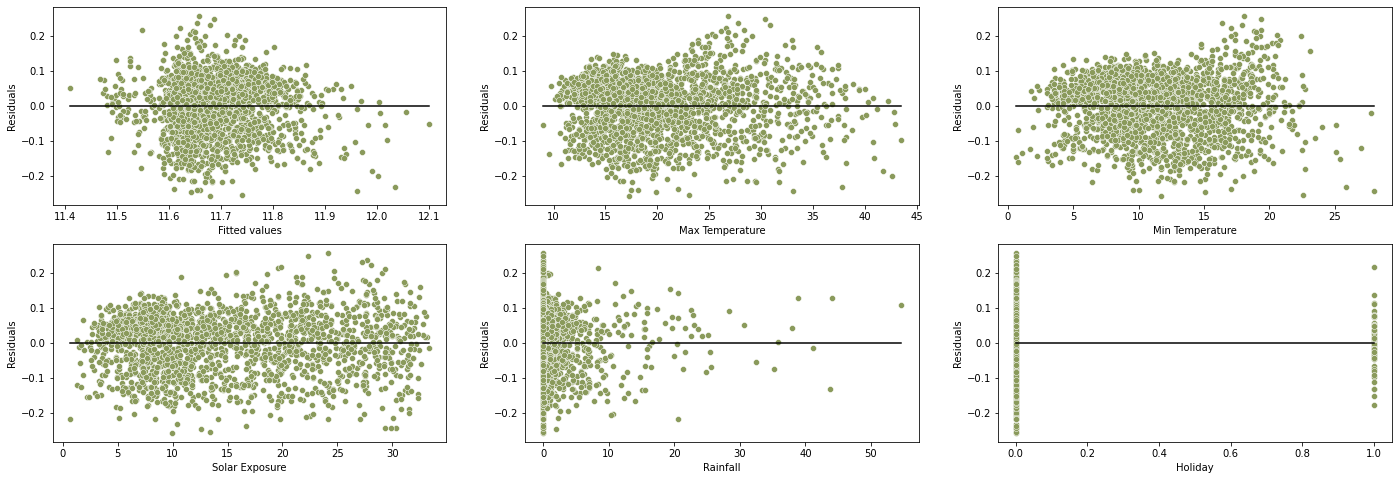

In [15]:
# Visualizing residuals of all the predictor variables again
fig = plt.figure(figsize=(24, 8))
plt.subplot(2, 3, 1)
sns.scatterplot(x=model2.fittedvalues, y=model2.resid, color = '#8A9A5B')
sns.lineplot(x=[model2.fittedvalues.min(), model2.fittedvalues.max()], y=[0,0], color='black')
plt.xlabel('Fitted values')
plt.ylabel('Residuals')

plt.subplot(2, 3, 2)
sns.scatterplot(x=df.max_temperature, y=model2.resid, color = '#8A9A5B')
sns.lineplot(x=[df.max_temperature.min(), df.max_temperature.max()], y=[0,0], color='black')
plt.xlabel('Max Temperature')
plt.ylabel('Residuals')

plt.subplot(2, 3, 3)
sns.scatterplot(x=df.min_temperature, y=model2.resid, color = '#8A9A5B')
sns.lineplot(x=[df.min_temperature.min(), df.min_temperature.max()], y=[0,0], color='black')
plt.xlabel('Min Temperature')
plt.ylabel('Residuals')

plt.subplot(2, 3, 4)
sns.scatterplot(x=df.solar_exposure, y=model2.resid, color = '#8A9A5B')
sns.lineplot(x=[df.solar_exposure.min(), df.solar_exposure.max()], y=[0,0], color='black')
plt.xlabel('Solar Exposure')
plt.ylabel('Residuals')

plt.subplot(2, 3, 5)
sns.scatterplot(x=df.rainfall, y=model2.resid, color = '#8A9A5B')
sns.lineplot(x=[df.rainfall.min(), df.rainfall.max()], y=[0,0], color='black')
plt.xlabel('Rainfall')
plt.ylabel('Residuals')

plt.subplot(2, 3, 6)
sns.scatterplot(x=df.holiday, y=model2.resid, color = '#8A9A5B')
sns.lineplot(x=[df.holiday.min(), df.holiday.max()], y=[0,0], color='black')
plt.xlabel('Holiday')
plt.ylabel('Residuals')

#### Model 2 Conclusions: 
- Our R-squared significantly better
- The residual plots indicate that linear assumptions have been satisfied

In [16]:
# Model 2.5 : checking if interaction term of max_temperature*holiday improves our model
ols_object = smf.ols(formula = 'np.log(demand)~max_temperature+I(max_temperature**2)+min_temperature+\
I(min_temperature**2)+solar_exposure+I(solar_exposure**2)+holiday*max_temperature+school_day+holiday+\
rainfall', data = df)

model25 = ols_object.fit()
print(model25.summary())

pred = model25.predict(df)
print(np.sqrt((df['demand']-pred)**2).mean())

                            OLS Regression Results                            
Dep. Variable:         np.log(demand)   R-squared:                       0.489
Model:                            OLS   Adj. R-squared:                  0.486
Method:                 Least Squares   F-statistic:                     200.2
Date:                Sun, 12 Mar 2023   Prob (F-statistic):          1.97e-296
Time:                        16:31:03   Log-Likelihood:                 2275.3
No. Observations:                2106   AIC:                            -4529.
Df Residuals:                    2095   BIC:                            -4466.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

### Code fitting the final model

*By Jonny Myong and Jamie Park*


### Removing influential points

Text(0, 0.5, 'Studentized Residuals')

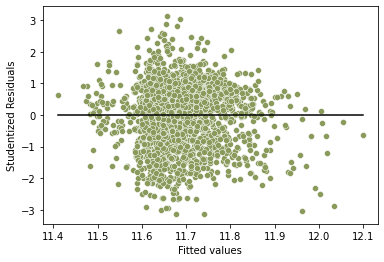

In [17]:
# Plotting studentized residuals
out = model2.outlier_test()

sns.scatterplot(x = (model2.fittedvalues), y=(out.student_resid), color = '#8A9A5B')
sns.lineplot(x = [model2.fittedvalues.min(), model2.fittedvalues.max()], y = [0,0], color = 'black')
plt.xlabel('Fitted values')
plt.ylabel('Studentized Residuals')

In [18]:
# Number of outliers
np.sum((np.abs(out.student_resid)>3))

6

In [19]:
# Computing the leverage statistic for each observation
influence = model2.get_influence()
leverage = influence.hat_matrix_diag

In [20]:
out = model2.outlier_test()

In [21]:
# High leverage points
average_leverage = (model2.df_model+1)/model2.nobs
high_leverage_threshold = 4*average_leverage
np.sum(leverage>high_leverage_threshold)

41

In [22]:
# Dropping influential points from data
df_filtered = df.drop(np.intersect1d(np.where(np.abs(out.student_resid)>3)[0],
                                           (np.where(leverage>high_leverage_threshold)[0])))

In [23]:
# Finding the number of influential point(s)
df.shape[0]-df_filtered.shape[0]

1

In [24]:
ols_object = smf.ols(formula = 'np.log(demand)~max_temperature+I(max_temperature**2)+min_temperature+I(min_temperature**2)+solar_exposure+I(solar_exposure**2)+school_day+holiday+rainfall', data = df_filtered)
model3 = ols_object.fit()
model3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         np.log(demand)   R-squared:                       0.491
Model:                            OLS   Adj. R-squared:                  0.489
Method:                 Least Squares   F-statistic:                     224.5
Date:                Sun, 12 Mar 2023   Prob (F-statistic):          1.90e-299
Time:                        16:31:06   Log-Likelihood:                 2278.4
No. Observations:                2105   AIC:                            -4537.
Df Residuals:                    2095   BIC:                            -4480.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                  12.4076      0.021    602.227      0.000      12.367      12.448
max_temperature            -0.0454      0.002    -22.031      0.000      -0.049      -0.041
I(max_temperature ** 2)     0.0010   4.05e-05     24.390      0.000       0.001       0.001
min_temperature            -0.0303      0.002    -14.714      0.000      -0.034      -0.026
I(min_temperature ** 2)     0.0012   8.06e-05     14.911      0.000       0.001       0.001
solar_exposure             -0.0104      0.001     -9.307      0.000      -0.013      -0.008
I(solar_exposure ** 2)      0.0002   3.15e-05      7.393      0.000       0.000       0.000
school_day                  0.0293      0.004      7.368      0.000       0.022       0.037
holiday                    -0.1140      0.010    -11.705      0.000      -0.133      -0.095
rainfall                   -0.0021      0.000     -5.002      0.000      -0.003      -0.001
==============================================================================
Omnibus:                       47.690   Durbin-Watson:                   1.026
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               49.970
Skew:                          -0.367   Prob(JB):                     1.41e-11
Kurtosis:                       2.828   Cond. No.                     7.66e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.66e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Autocorrelation Section

*By Jamie Park*


Besides all of the code above, we also conducted autocorrelation to see if adding lag better furthered our results

In [25]:
# Changing variables based on earlier observations to prepare for autocorrelation
df_filtered['demand'] = np.log(df_filtered['demand'])
df_filtered['max_temperature_squared'] = (df_filtered['max_temperature'])**2
df_filtered['min_temperature_squared'] = (df_filtered['min_temperature'])**2
df_filtered['solar_exposure_squared'] = (df_filtered['solar_exposure'])**2

In [26]:
# Dropping variables irrelevant to our model-building
df_filtered = df_filtered.drop(['RRP', 'demand_pos_RRP', 'RRP_positive',
                                'demand_neg_RRP', 'RRP_negative', 'frac_at_neg_RRP'], axis=1)

In [27]:
# Defining base_vars to hold our main predictor variables
base_vars = ['max_temperature', 'max_temperature_squared', 'min_temperature', \
             'min_temperature_squared', 'solar_exposure', 'solar_exposure_squared', \
             'holiday', 'rainfall']

In [28]:
# Defining functions utilized for autocorrelation
import numpy.ma as ma
from scipy.stats.stats import pearsonr, normaltest
from scipy.spatial.distance import correlation

# Building a model based on data up to a certain date
def build_model(features):
    X=sm.add_constant(df_filtered[df_filtered['date']<date][features])
    y=df_filtered[df_filtered['date']<date]['demand']
    model = sm.OLS(y, X, missing='drop').fit()
    predictions = model.predict(X)
    res = y-predictions
    return model, res

def plt_residual(res):
    plt.plot(range(len(res)), res, color = '#8A9A5B') 
    plt.ylabel('Residual')
    plt.xlabel('Day')

In [29]:
# Performing autocorrelation on 2019 data
# Creating a datetime index of everyday in 2019

from datetime import date, timedelta

sdate = date(2019,1,1)
edate = date(2020,1,1)
all_dates = pd.date_range(sdate, edate-timedelta(days=1), freq='d')

In [30]:
# Defining get_rmse to return the RMSE and energy demand predictions for every day in 2019
# given lags

def get_rmse(lags):
    predictions = pd.DataFrame()
    sse = 0
    for date in all_dates:
        model, residuals = build_model(base_vars+lags)
        subset = df_filtered[df_filtered['date'] == date]
        temp = model.predict(sm.add_constant(subset[base_vars+lags], has_constant='add'))
        sse += ((np.exp(subset['demand']) - np.exp(temp.values))**2).sum()
        predictions = pd.concat([predictions, temp]) 
    print(model.summary())
    
    return np.sqrt(sse/365), predictions

In [32]:
# Systematically going through 1_day to 6_day lags (every day)
# to observe which increase(s) R-squared and decrease(s) RMSE the most

lags = []
days = []
rmses = []
for num in np.arange(1, 7, 1):
    var_name = 'demand_lag_' + str(num) + '_day'
    df_filtered[var_name] = df_filtered['demand'].shift(num)
    
    days.append(num)
    rmses.append(get_rmse([var_name]))
    
lag_models = pd.DataFrame({'day_lag':days , 'rmse':rmses})
lag_models

                            OLS Regression Results                            
Dep. Variable:                 demand   R-squared:                       0.614
Model:                            OLS   Adj. R-squared:                  0.612
Method:                 Least Squares   F-statistic:                     256.5
Date:                Sun, 12 Mar 2023   Prob (F-statistic):          2.45e-292
Time:                        16:31:11   Log-Likelihood:                 1800.6
No. Observations:                1459   AIC:                            -3581.
Df Residuals:                    1449   BIC:                            -3528.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

                            OLS Regression Results                            
Dep. Variable:                 demand   R-squared:                       0.455
Model:                            OLS   Adj. R-squared:                  0.452
Method:                 Least Squares   F-statistic:                     134.2
Date:                Sun, 12 Mar 2023   Prob (F-statistic):          1.20e-183
Time:                        16:31:23   Log-Likelihood:                 1545.9
No. Observations:                1456   AIC:                            -3072.
Df Residuals:                    1446   BIC:                            -3019.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

StopIteration: 

StopIteration: 

In [33]:
# Systematically going through 7_day to 28_day lags (every week) 
# to observe which increase(s) R-squared and decrease(s) RMSE the most

lags = []
days = []
rmses = []
for num in np.arange(7, 29, 7):
    var_name = 'demand_lag_' + str(num) + '_day'
    lags.append(var_name)
    df_filtered[var_name] = df_filtered['demand'].shift(num)
    
    days.append(num)
    rmses.append(get_rmse([var_name]))
    
lag_models = pd.DataFrame({'day_lag':days , 'rmse':rmses})
lag_models

                            OLS Regression Results                            
Dep. Variable:                 demand   R-squared:                       0.695
Model:                            OLS   Adj. R-squared:                  0.693
Method:                 Least Squares   F-statistic:                     365.1
Date:                Sun, 12 Mar 2023   Prob (F-statistic):               0.00
Time:                        16:31:39   Log-Likelihood:                 1965.0
No. Observations:                1453   AIC:                            -3910.
Df Residuals:                    1443   BIC:                            -3857.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

                            OLS Regression Results                            
Dep. Variable:                 demand   R-squared:                       0.643
Model:                            OLS   Adj. R-squared:                  0.640
Method:                 Least Squares   F-statistic:                     284.3
Date:                Sun, 12 Mar 2023   Prob (F-statistic):          2.57e-310
Time:                        16:31:53   Log-Likelihood:                 1827.7
No. Observations:                1432   AIC:                            -3635.
Df Residuals:                    1422   BIC:                            -3583.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

StopIteration: 

StopIteration: 

In [34]:
# Now that we have identified 1_day, 7_day, and 14_day lags as the most effective,
# we create a model including them

lags = []
days = []
rmses = []
for num in [1, 7, 14]:
    var_name = 'demand_lag_' + str(num) + '_day'
    lags.append(var_name)
    df_filtered[var_name] = df_filtered['demand'].shift(num)
    
final_model, residuals = build_model(base_vars+lags)
rmse, predictions = get_rmse(lags)
print('RMSE' + str(rmse))

                            OLS Regression Results                            
Dep. Variable:                 demand   R-squared:                       0.776
Model:                            OLS   Adj. R-squared:                  0.775
Method:                 Least Squares   F-statistic:                     452.3
Date:                Sun, 12 Mar 2023   Prob (F-statistic):               0.00
Time:                        16:31:58   Log-Likelihood:                 2180.1
No. Observations:                1446   AIC:                            -4336.
Df Residuals:                    1434   BIC:                            -4273.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

### Taking a closer look at how each lag (1_day, 1_week, 2_week) improved our model

#### Adding 1_day lag

In [35]:
df_filtered['demand_lag_1_day']=df_filtered['demand'].shift(1)

predictions = pd.DataFrame()
sse = 0
for date in all_dates:
    model, residuals = build_model(base_vars+['demand_lag_1_day'])
    subset = df_filtered[df_filtered['date'] == date]
    temp = model.predict(sm.add_constant(subset[base_vars+['demand_lag_1_day']], has_constant='add'))
    sse += ((np.exp(subset['demand']) - np.exp(temp.values))**2).sum()
    predictions = pd.concat([predictions, temp]) 

                            OLS Regression Results                            
Dep. Variable:                 demand   R-squared:                       0.625
Model:                            OLS   Adj. R-squared:                  0.623
Method:                 Least Squares   F-statistic:                     335.1
Date:                Sun, 12 Mar 2023   Prob (F-statistic):               0.00
Time:                        16:32:03   Log-Likelihood:                 2260.9
No. Observations:                1823   AIC:                            -4502.
Df Residuals:                    1813   BIC:                            -4447.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

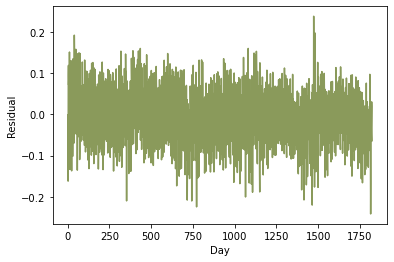

In [36]:
model, residuals = build_model(base_vars+['demand_lag_1_day'])
print(model.summary())
plt_residual(residuals)

Text(0, 0.5, 'Predicted Demand (Log)')

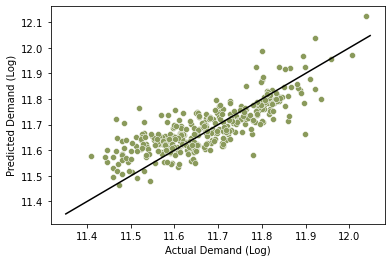

In [37]:
sns.scatterplot(x=df_filtered['demand'], y=predictions[0], color = '#8A9A5B')
x_var = np.linspace(min(df_filtered['demand']), max(df_filtered['demand']))
y_var = x_var
plt.plot(x_var, y_var, color='black')
plt.xlabel('Actual Demand (Log)')
plt.ylabel('Predicted Demand (Log)')

In [38]:
np.sqrt(sse/365)

8181.395202350846

#### Adding 7_day lag

In [39]:
df_filtered['demand_lag_7_day']=df_filtered['demand'].shift(7)

predictions = pd.DataFrame()
sse = 0
for date in all_dates:
    model, residuals = build_model(base_vars+['demand_lag_1_day', 'demand_lag_7_day'])
    subset = df_filtered[df_filtered['date'] == date]
    temp = model.predict(sm.add_constant(subset[base_vars+['demand_lag_1_day', 'demand_lag_7_day']], has_constant='add'))
    sse += ((np.exp(subset['demand']) - np.exp(temp.values))**2).sum()
    predictions = pd.concat([predictions, temp]) 

                            OLS Regression Results                            
Dep. Variable:                 demand   R-squared:                       0.743
Model:                            OLS   Adj. R-squared:                  0.742
Method:                 Least Squares   F-statistic:                     523.3
Date:                Sun, 12 Mar 2023   Prob (F-statistic):               0.00
Time:                        16:32:08   Log-Likelihood:                 2601.1
No. Observations:                1817   AIC:                            -5180.
Df Residuals:                    1806   BIC:                            -5120.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

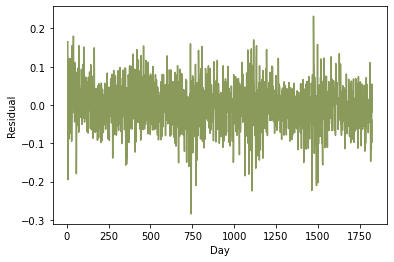

In [40]:
model, residuals = build_model(base_vars+['demand_lag_1_day', 'demand_lag_7_day'])
print(model.summary())
plt_residual(residuals)  

Text(0, 0.5, 'Predicted Demand (Log)')

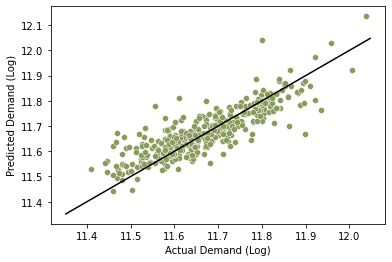

In [41]:
sns.scatterplot(x=df_filtered['demand'], y=predictions[0], color = '#8A9A5B')
x_var = np.linspace(min(df_filtered['demand']), max(df_filtered['demand']))
y_var = x_var
plt.plot(x_var, y_var, color='black')
plt.xlabel('Actual Demand (Log)')
plt.ylabel('Predicted Demand (Log)')

In [42]:
np.sqrt(sse/365)

7363.401682793166

#### Adding 14_day lag

In [43]:
df_filtered['demand_lag_14_day']=df_filtered['demand'].shift(14)

predictions = pd.DataFrame()
sse = 0
for date in all_dates:
    model, residuals = build_model(base_vars+['demand_lag_1_day', 'demand_lag_7_day', 'demand_lag_14_day'])
    subset = df_filtered[df_filtered['date'] == date]
    temp = model.predict(sm.add_constant(subset[base_vars+['demand_lag_1_day', 'demand_lag_7_day', 'demand_lag_14_day']], has_constant='add'))
    sse += ((np.exp(subset['demand']) - np.exp(temp.values))**2).sum()
    predictions = pd.concat([predictions, temp]) 

                            OLS Regression Results                            
Dep. Variable:                 demand   R-squared:                       0.774
Model:                            OLS   Adj. R-squared:                  0.772
Method:                 Least Squares   F-statistic:                     558.2
Date:                Sun, 12 Mar 2023   Prob (F-statistic):               0.00
Time:                        16:32:14   Log-Likelihood:                 2704.2
No. Observations:                1810   AIC:                            -5384.
Df Residuals:                    1798   BIC:                            -5318.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

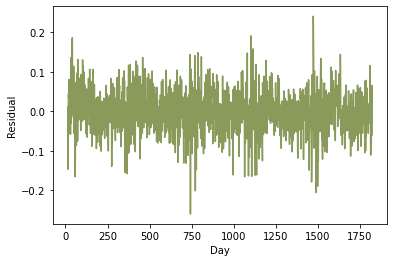

In [44]:
model, residuals = build_model(base_vars+['demand_lag_1_day', 'demand_lag_7_day', 'demand_lag_14_day'])
print(model.summary())
plt_residual(residuals)  

Text(0, 0.5, 'Predicted Demand (Log)')

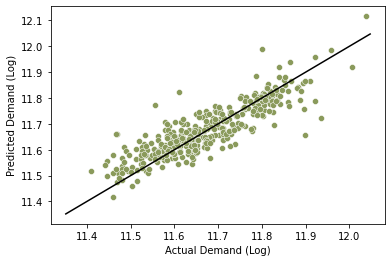

In [45]:
sns.scatterplot(x=df_filtered['demand'], y=predictions[0], color = '#8A9A5B')
x_var = np.linspace(min(df_filtered['demand']), max(df_filtered['demand']))
y_var = x_var
plt.plot(x_var, y_var, color='black')
plt.xlabel('Actual Demand (Log)')
plt.ylabel('Predicted Demand (Log)')

In [46]:
np.sqrt(sse/365)

6985.228837669801